In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras import losses
from tensorflow.keras.datasets import mnist

In [2]:
from tensorflow.keras.optimizers import Adam
import numpy as np

In [3]:
def make_discriminator():
    input_layer = Input(shape=(28,28,1))
    x = layers.Conv2D(64, (3,3), strides=(2,2), padding="same")(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(1, activation="softmax")(x)
    return Model(inputs=[input_layer], outputs=[x], name="Discriminator")
discriminator = make_discriminator()

2023-04-21 14:34:09.670367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-21 14:34:09.670740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [4]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                     

In [5]:
def make_generator(latent_dim):
    noise = Input(shape=(latent_dim,))
    x = layers.Dense(7*7*128)(noise)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((7,7,128))(x)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x) # Deconvoltion
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x) # Deconvoltion
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)
    return Model(inputs=[noise], outputs=[x], name="Generator")

latent_dim = 128
generator = make_generator(latent_dim)
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                         

In [6]:
class MyGan(Model):
    def __init__(self, generator, discriminator, batch_size=64):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
    
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
    
    def train_step(self, batch):
        # Sample random points in the latent space
        batch_size = self.batch_size
        real_images = batch
        dloss_fn = self.discriminator_loss
        gloss_fn = self.generator_loss
        d_optimizer = self.discriminator_optimizer
        g_optimizer = self.generator_optimizer
        # print(type(real_images))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        # Decode them to fake images
        generated_images = generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((tf.shape(real_images)[0], 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images)
            d_loss = dloss_fn(labels, predictions)
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = discriminator(generator(random_latent_vectors))
            g_loss = gloss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
        return {"Discriminator loss":d_loss, "Generator loss":g_loss}

In [7]:
my_gan = MyGan(generator, discriminator)

In [8]:
generator_loss = losses.BinaryCrossentropy()
discriminator_loss = losses.BinaryCrossentropy()
generator_optimizer = Adam(learning_rate=1e-4)
discriminator_optimizer = Adam(learning_rate=1e-3)


my_gan.compile(generator_loss=generator_loss,
               discriminator_loss=discriminator_loss,
               generator_optimizer=generator_optimizer,
               discriminator_optimizer=discriminator_optimizer)

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

batch_size=64
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [10]:
hist = my_gan.fit(dataset, epochs=100, batch_size=64)

Epoch 1/100


2023-04-21 14:34:11.268335: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-21 14:34:11.272196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1094/1094 [==============================] - 105s 92ms/step - Discriminator loss: 0.0492 - Generator loss: 30.8670
Epoch 2/100
1094/1094 [==============================] - 1093s 1s/step - Discriminator loss: 0.1643 - Generator loss: 6.8796
Epoch 3/100
1094/1094 [==============================] - 101s 92ms/step - Discriminator loss: 0.1488 - Generator loss: 5.3102
Epoch 4/100
1094/1094 [==============================] - 101s 92ms/step - Discriminator loss: 0.2043 - Generator loss: 3.8663
Epoch 5/100
1094/1094 [==============================] - 101s 92ms/step - Discriminator loss: 0.2653 - Generator loss: 3.1546
Epoch 6/100
1094/1094 [==============================] - 100s 92ms/step - Discriminator loss: 0.3277 - Generator loss: 2.4808
Epoch 7/100
1094/1094 [==============================] - 100s 92ms/step - Discriminator loss: 0.3654 - Generator loss: 2.2871
Epoch 8/100
1094/1094 [==============================] - 100s 91ms/step - Discriminator loss: 0.3924 - Generator loss: 2.0493
Epoc

KeyboardInterrupt: 

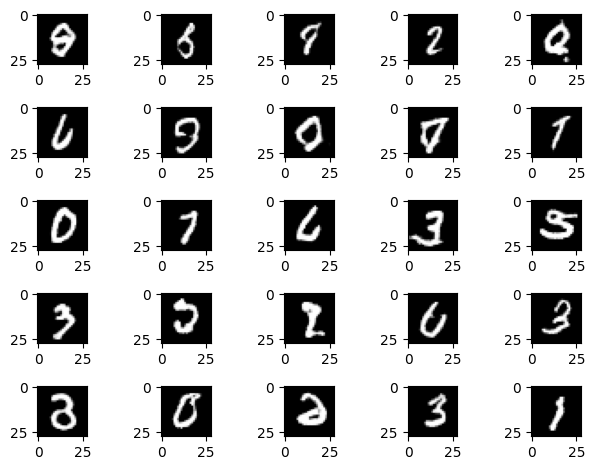

In [15]:
from matplotlib import pyplot as plt

batch_size = 25
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = generator(random_latent_vectors)
for i in range(batch_size):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i], cmap="gray")
plt.tight_layout()
plt.show()